# July 29th, 2018
## Benjamin Adam Catching
## Andino Lab, Summer Rotation
## Polio-virus DIPs Project

New images have been taken, analysis the images to determine the percentage of infected.

In [26]:
# Import necessary packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import seaborn as sns
import skimage.measure
import skimage.filters

In [2]:
# Define the root path
root = 'data/07.27_HeLa_TIP_Hong/'
# List of the rest of the 40X images
image_40X = []
for i in range(5):
    temp_list = []
    for j in range(3):
        image_path = root + '#%d/40x-%d.tif' % (i+1, j+1)
        #print('>', image_path)
        try:
            image = skimage.io.imread(image_path)
            temp_list.append(image)
        except:
            print("No file found for ", image_path)
    image_40X.append(temp_list)

No file found for  data/07.27_HeLa_TIP_Hong/#1/40x-3.tif


In [3]:
from tools import microfluidics_analysis as ma

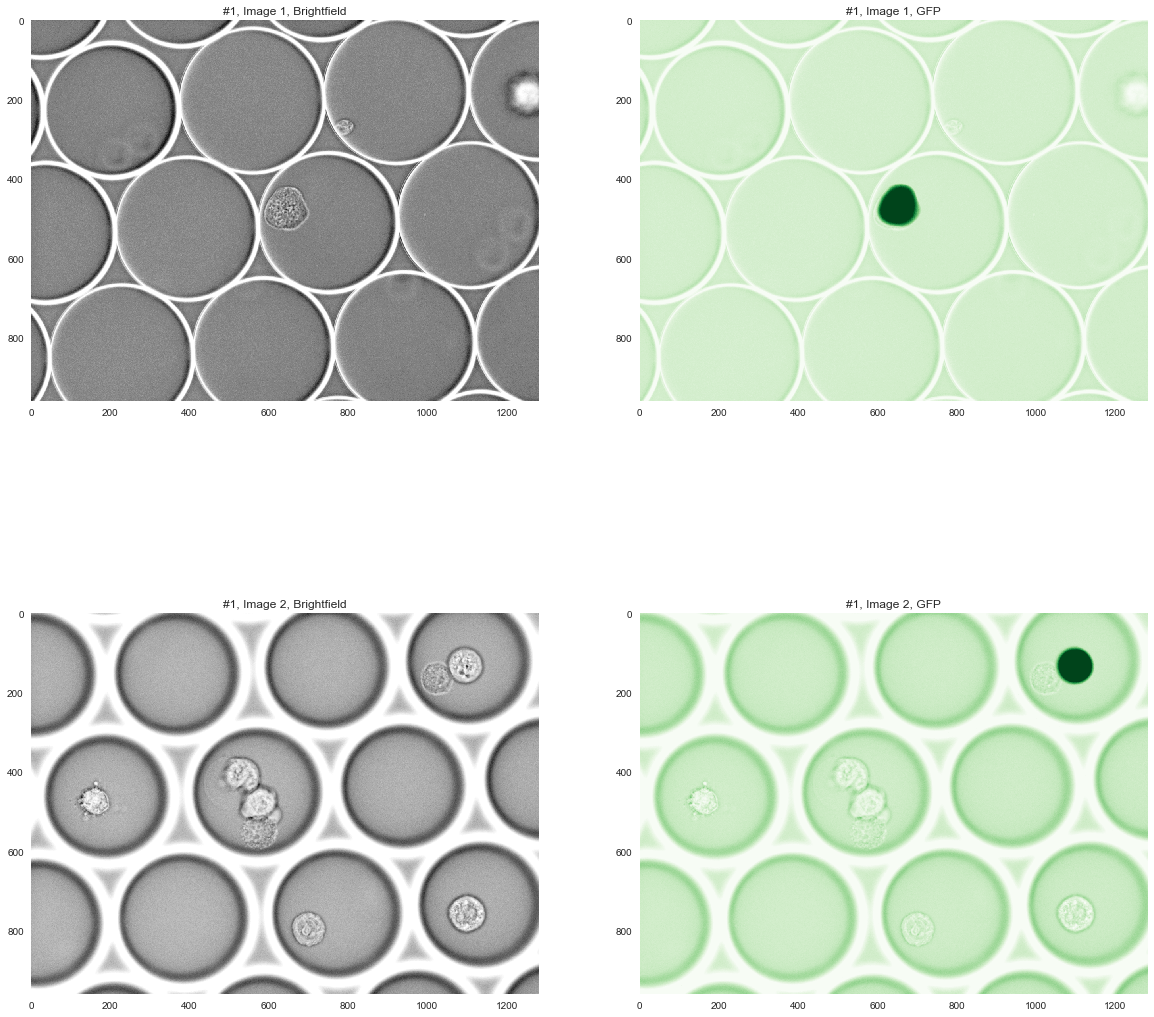

In [4]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax[0, 0].imshow(image_40X[0][0][:, :, 0], cmap=plt.cm.Greys)
    ax[0, 0].set_title('#1, Image 1, Brightfield')
    ax[0, 1].imshow(image_40X[0][0][:, :, 1], cmap=plt.cm.Greens)
    ax[0, 1].set_title('#1, Image 1, GFP')
    ax[1, 0].imshow(image_40X[0][1][:, :, 0], cmap=plt.cm.Greys)
    ax[1, 0].set_title('#1, Image 2, Brightfield')
    ax[1, 1].imshow(image_40X[0][1][:, :, 1], cmap=plt.cm.Greens)
    ax[1, 1].set_title('#1, Image 2, GFP')
plt.show(
)

For 40X, the are .226 microns per pixel. For 10X there are .899 microns per pixel.

In [5]:
# Test segmentation
test_image = ma.BulkDroplet(filename='data/07.27_HeLa_TIP_Hong/#1/40x-1.tif',
                            micron_per_pixel=0.226,
                            gfp_thresh=10,
                            multi_channel=True)

The file is updated


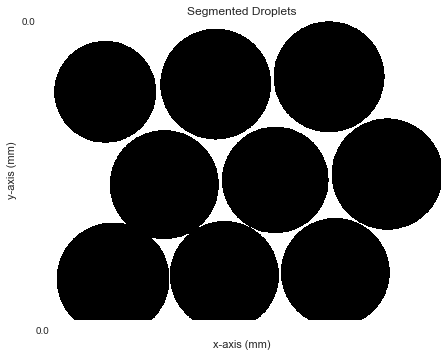

In [6]:
temp_droplet_labeled, temp_droplet_props = test_image.droplet_segment(testing=True)

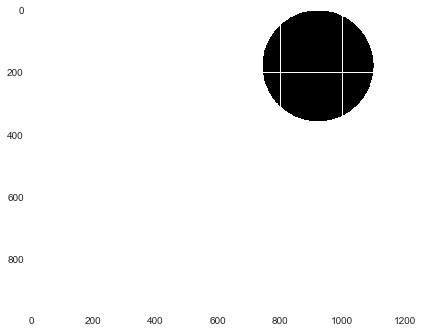

In [24]:
plt.imshow(temp_droplet_labeled==1)
plt.show()

In [8]:
droplet_cells_list, gfp_droplets = ma.cell_bright_gfp_thresh(temp_droplet_labeled, 
                                                             temp_droplet_props,
                                                             'data/07.27_HeLa_TIP_Hong/#1/40x-1.tif',
                                                             'data/07.27_HeLa_TIP_Hong/#1/40x-1.tif')

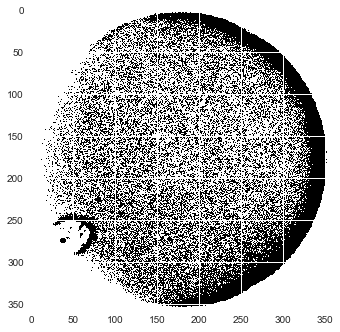

In [13]:
plt.imshow(gfp_droplets[0])
plt.show()

In [22]:
brightfield_test = ma.cells_from_droplet(temp_droplet_labeled, 
                                         image_40X[0][0][:, :, 0],
                                         1, 
                                         size_thresh=100)

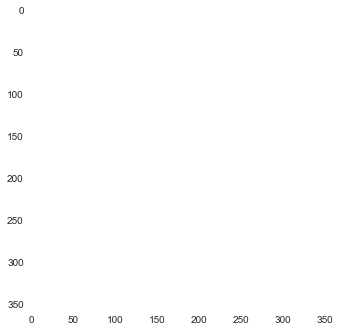

In [23]:
plt.imshow(brightfield_test)
plt.show()

In [28]:
bright_droplet_props = skimage.measure.regionprops(temp_droplet_labeled==1, 
                                                   image_40X[0][0][:, :, 0])

# List of segmented droplets
bright_droplets = []
droplet_masks = []

# Assign images
cell_droplet = bright_droplets[1]

# Remove any hot pixels
selem = skimage.morphology.disk(3)
cell_droplet_median = skimage.filters.median(cell_droplet, selem)

# Create a gaussian blur of the image and subtract from median image
cell_droplet_gaussian_blur = skimage.filters.gaussian(cell_droplet_median, sigma=15)
cell_droplet_sub_gaussian = cell_droplet_median - cell_droplet_gaussian_blur

# Perform a Scharr operation on the no cell droplet
cell_droplet_temp_scharr = skimage.filters.scharr(cell_droplet_sub_gaussian, droplet_masks[droplet_num])
# Otsu threshold the scharr image
cell_droplet_thresh = skimage.filters.threshold_otsu(cell_droplet_temp_scharr)
# Fill holes created from the otsu threshold
cell_droplet_filled = scipy.ndimage.binary_fill_holes(cell_droplet_temp_scharr > cell_droplet_thresh)
# Try to fill any partial no_cell_filled
blur_droplet_cells = skimage.filters.gaussian(cell_droplet_filled, 2)
smooth_droplet_cells = blur_droplet_cells > .25

# Now that objects have been thresholded in the droplets, label and get props
cell_droplet_labels = skimage.measure.label(smooth_droplet_cells, background=0, return_num=False)

# Get regionprops and filter based on them
cell_droplet_props = skimage.measure.regionprops(cell_droplet_labels)

# Create a blank region of the original image
all_cells = np.zeros(cell_droplet.shape)

# First with no cells
for index, prop in enumerate(cell_droplet_props):
    # If the region properties are within the threshold
    if 1500 <= prop.area:
        if prop.area <= 10000 and prop.extent > .2:
            # Select the region
            temp_seg = cell_droplet_labels == index + 1
            filled_seg = temp_seg
            # Add to the blank image
            all_cells = all_cells + filled_seg

TypeError: Label image must be of integral type.